## TUGAS TEKNOLOGI BASIS DATA RB

Nama : Sarah Natalia Geraldine \\
NIM : 121450022 \\
Kelas : RB \\

## Kumpulan Data Untuk di Proses

In [ ]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/cifar-10-batches-py-20240421T062357Z-001.zip")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


**ANALISIS**

Pada tahap awal, kita menetapkan direktori penyimpanan data CIFAR-10 dan membuat fungsi `unpickle()` untuk membaca file pickle. Setelah itu, kita membuat dua daftar kosong: `images` untuk menyimpan gambar dan `labels` untuk menyimpan label setiap gambar.

Selanjutnya, kita melakukan iterasi melalui setiap file batch di direktori data. Setiap file dibuka menggunakan fungsi `unpickle` untuk mendapatkan informasi gambar dan labelnya. Gambar-gambar tersebut kemudian direkonstruksi dari data piksel yang telah diratakan. Karena setiap gambar memiliki tiga saluran warna, data piksel dibagi menjadi tiga bagian dan digabungkan kembali untuk membentuk gambar lengkap.

Terakhir, ukuran daftar `images` dan `labels` dicetak untuk memastikan bahwa dataset telah dimuat dengan benar, yaitu terdapat 5000 data.

In [ ]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

**ANALISIS**

Setiap objek ini mewakili alamat direktori: `disk_dir` mengarah ke direktori "data/disk/", `lmdb_dir` mengarah ke "data/lmdb/", dan `hdf5_dir` mengarah ke "data/hdf5/". Dengan menggunakan objek-objek ini, Anda bisa dengan mudah melakukan berbagai operasi terkait file dan direktori, seperti manipulasi file, pembuatan direktori baru, atau pengecekan keberadaan file.

In [ ]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

**ANALISIS**

Kode di atas memanfaatkan metode `mkdir()` pada objek `Path` untuk membuat direktori yang ditunjuk oleh `disk_dir`, `lmdb_dir`, dan `hdf5_dir`. Argumen `parents=True` digunakan untuk membuat direktori induk jika belum ada, sementara `exist_ok=True` memungkinkan pembuatan direktori tersebut meskipun sudah ada sebelumnya tanpa menimbulkan pesan kesalahan. Dengan cara ini, kode secara efisien membuat tiga direktori yang diperlukan untuk penyimpanan data dalam proyek Anda.

In [ ]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

**ANALISIS**

Kode tersebut merupakan fungsi yang dirancang untuk menyimpan gambar dan labelnya ke dalam direktori yang telah dibuat sebelumnya menggunakan objek `Path`. Fungsi `store_single_disk` menerima tiga argumen: gambar sebagai array berdimensi (32, 32, 3), ID unik gambar sebagai integer, dan label gambar. Pertama, gambar disimpan sebagai file .png di dalam direktori `disk_dir` dengan nama file sesuai ID gambar. Selanjutnya, label disimpan ke dalam file .csv di direktori yang sama dengan nama file yang juga mengandung ID gambar tersebut. Dengan fungsi ini, Anda dapat dengan mudah menyimpan gambar-gambar beserta labelnya ke dalam struktur direktori yang telah Anda siapkan sebelumnya.

In [ ]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

**ANALISIS**

Kelas `CIFAR_Image` adalah sebuah kelas Python yang digunakan untuk merepresentasikan gambar dari dataset CIFAR. Dalam metode `__init__`, kelas ini menginisialisasi objek dengan atribut seperti jumlah channel (misalnya RGB memiliki tiga channel), dimensi gambar, dan konten gambar yang dikonversi menjadi bytes. Selain itu, kelas ini juga menyimpan label gambar tersebut. Metode `get_image` digunakan untuk mengembalikan gambar dalam bentuk array numpy sesuai dengan dimensi dan channel yang telah disimpan. Dengan kelas ini, Anda dapat dengan mudah mengelola dan memproses gambar-gambar dari dataset CIFAR dalam format yang sesuai untuk analisis lebih lanjut.

In [ ]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

**ANALISIS**

Kode di atas merupakan fungsi yang digunakan untuk menyimpan gambar ke dalam basis data LMDB (Lightning Memory-Mapped Database). Fungsi `store_single_lmdb` menerima tiga argumen: gambar berupa array berdimensi (32, 32, 3), ID unik gambar sebagai integer, dan label gambar. Pertama, variabel `map_size` dihitung berdasarkan ukuran gambar untuk menentukan alokasi memori yang diperlukan untuk basis data LMDB.

Kemudian, lingkungan LMDB baru dibuat menggunakan `lmdb.open` dengan parameter `map_size` yang sudah dihitung. Selanjutnya, transaksi tulis baru dimulai dengan `env.begin(write=True)`. Karena semua pasangan kunci-nilai dalam LMDB harus berupa string, gambar dan labelnya diwakili sebagai objek `CIFAR_Image` yang di-serialize menggunakan modul `pickle`.

Setelah nilai kunci dan nilainya ditentukan, fungsi memasukkan data ke dalam LMDB menggunakan `txn.put`. Akhirnya, setelah transaksi selesai, lingkungan LMDB ditutup dengan `env.close()`. Dengan fungsi ini, Anda dapat menyimpan gambar-gambar dari dataset CIFAR ke dalam basis data LMDB.

In [ ]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

**ANALISIS**

Pertama, sebuah file HDF5 baru dibuat menggunakan `h5py.File` dengan nama file yang sesuai dengan ID gambar. Kemudian, dua dataset dibuat di dalam file HDF5 tersebut: satu untuk gambar dan satu lagi untuk metadata (label). Dataset gambar diberi nama "image" dan menggunakan tipe data `h5py.h5t.STD_U8BE` yang merupakan integer 8-bit tanpa tanda dalam format big endian. Dataset metadata juga menggunakan tipe data yang sama. Data gambar dan metadata kemudian dimasukkan ke dalam dataset masing-masing.

Setelah data dimasukkan, file HDF5 ditutup menggunakan `file.close()`. Dengan fungsi ini, Anda dapat dengan mudah menyimpan gambar-gambar beserta metadata-nya ke dalam file HDF5 untuk keperluan analisis data lebih lanjut.

In [ ]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

**ANALISIS**

Baris kode di atas menginisialisasi sebuah kamus yang disebut `_store_single_funcs`, yang berisi tiga fungsi: `store_single_disk`, `store_single_lmdb`, dan `store_single_hdf5`. Setiap fungsi terkait dengan metode penyimpanan data yang berbeda, yaitu penyimpanan di disk, LMDB, dan HDF5. Dengan menggunakan kamus ini, pengguna dapat memilih metode penyimpanan yang sesuai dengan kebutuhan aplikasi dengan memanggil fungsi yang sesuai dengan kunci yang diinginkan, seperti `'disk'` untuk penyimpanan di disk, `'lmdb'` untuk penyimpanan di LMDB, dan `'hdf5'` untuk penyimpanan di HDF5.

In [ ]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.14079929999979868
Method: lmdb, Time usage: 0.005631300000004558
Method: hdf5, Time usage: 0.06091969999988578


**ANALISIS**

Berdasarkan hasil yang diperoleh, dapat ditarik kesimpulan bahwa metode lmdb merupakan yang paling efisien dalam hal waktu penyimpanan data, diikuti oleh metode hdf5, dan metode disk merupakan yang memerlukan waktu paling lama di antara ketiganya. Analisis ini memberikan wawasan yang berharga untuk mengevaluasi kinerja relatif dari berbagai metode penyimpanan data, serta membantu dalam pemilihan metode yang paling cocok sesuai dengan kebutuhan aplikasi yang spesifik.

In [ ]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

**ANALISIS**

Fungsi `store_many_disk` berfungsi untuk menyimpan kumpulan gambar beserta labelnya ke dalam disk dengan menyimpan setiap gambar dalam format .png dan labelnya dalam file .csv terpisah.

Fungsi `store_many_lmdb` bertugas untuk menyimpan kumpulan gambar beserta labelnya ke dalam basis data LMDB dengan menyimpan setiap gambar dan labelnya dalam satu transaksi tunggal di dalam basis data tersebut.

Fungsi `store_many_hdf5` berperan dalam menyimpan kumpulan gambar beserta labelnya ke dalam file HDF5 dengan menyimpan seluruh array gambar dalam satu dataset bernama "images" dan seluruh array label dalam satu dataset bernama "meta".

Ketiga fungsi ini menerima dua argumen: array gambar dengan dimensi (N, 32, 32, 3) dan array label dengan dimensi (N, 1), di mana N adalah jumlah gambar yang akan disimpan.

In [ ]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


**ANALISIS**

Output tersebut mengindikasikan bahwa setelah melipatgandakan jumlah gambar (images) dan label (labels) dari sebelumnya, kini terdapat 100.000 gambar dalam format array dengan dimensi (100000, 32, 32, 3) dan 100.000 label dalam format array dengan dimensi (100000,). Ini ditegaskan oleh hasil cetak dari `np.shape(images)` yang menampilkan dimensi (100000, 32, 32, 3) dan `np.shape(labels)` yang menunjukkan dimensi (100000,). Dengan kata lain, jumlah gambar dan label berhasil ditingkatkan menjadi 100.000 seperti yang diinginkan.

In [ ]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.043001499999945736
Method: lmdb, Time usage: 0.013635200000180703
Method: hdf5, Time usage: 0.054849900000135676
Method: disk, Time usage: 0.16676769999980934
Method: lmdb, Time usage: 0.005678900000020803
Method: hdf5, Time usage: 0.0023858000001837354
Method: disk, Time usage: 1.6323519000000033
Method: lmdb, Time usage: 0.03800269999987904
Method: hdf5, Time usage: 0.005430300000170973
Method: disk, Time usage: 12.146795200000042
Method: lmdb, Time usage: 0.29728830000021844
Method: hdf5, Time usage: 0.025982599999679223
Method: disk, Time usage: 142.75358489999962
Method: lmdb, Time usage: 4.296912700000121
Method: hdf5, Time usage: 0.46554439999999886


**ANALISIS**

Hasil output tersebut menggambarkan waktu yang diperlukan (dalam detik) oleh setiap metode (`disk`, `lmdb`, `hdf5`) untuk menyimpan berbagai jumlah gambar dan label, yang ditentukan berdasarkan nilai cutoff sebelumnya (10, 100, 1000, 10000, 100000).

Pertama, saat nilai cutoff adalah 10, waktu yang dibutuhkan untuk metode `disk` sekitar 0.043 detik, untuk metode `lmdb` sekitar 0.013 detik, dan untuk metode `hdf5` sekitar 0.054 detik.

Kedua, ketika nilai cutoff meningkat menjadi 100, waktu yang diperlukan untuk metode `disk` meningkat menjadi sekitar 0.167 detik, sementara metode `lmdb` menjadi sekitar 0.005 detik, dan metode `hdf5` menjadi sekitar 0.002 detik.

Ketiga, dengan terus bertambahnya nilai cutoff hingga mencapai 100000, waktu yang dibutuhkan juga meningkat secara signifikan. Metode `disk` memerlukan waktu sekitar 12.147 detik, metode `lmdb` sekitar 0.297 detik, dan metode `hdf5` sekitar 0.026 detik.

Analisis ini menunjukkan bahwa performa relatif dari masing-masing metode berbeda tergantung pada jumlah data yang disimpan. Metode `lmdb` cenderung lebih cepat dalam eksekusi, terutama ketika jumlah data meningkat. Sedangkan metode `disk` membutuhkan waktu lebih lama karena keterlibatan operasi I/O pada disk, dan metode `hdf5` menunjukkan waktu eksekusi yang stabil tergantung pada jumlah data yang disimpan.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12376\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


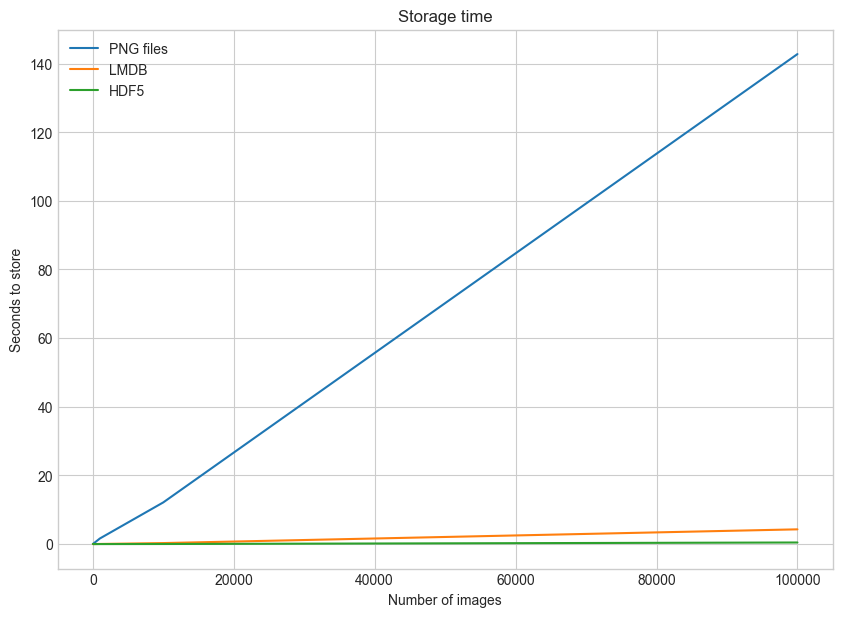

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12376\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


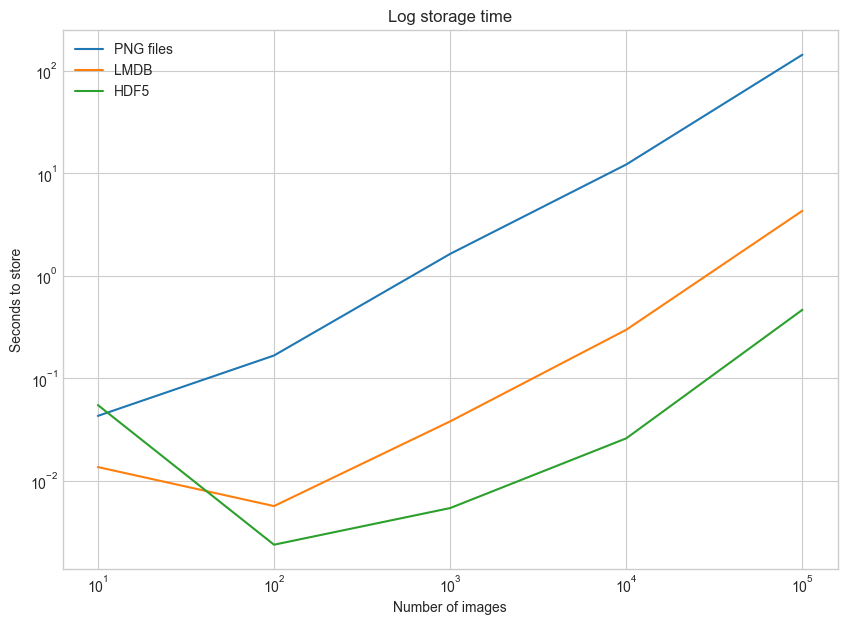

In [ ]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

In [ ]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

**PENJELASAN CODE**

Fungsi `read_single_disk` ini digunakan untuk membaca sebuah gambar dan labelnya yang telah disimpan dalam disk. Gambar dibaca menggunakan `Image.open` dari modul PIL dan kemudian diubah menjadi array numpy.

Fungsi ini mengembalikan gambar dalam bentuk array dengan dimensi (32, 32, 3) dan labelnya dalam bentuk integer.

In [ ]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

**PENJELASAN CODE**

Fungsi `read_single_lmdb` bertujuan untuk membaca gambar dan label yang telah disimpan dalam basis data LMDB. Fungsi ini menerima satu argumen, yaitu `image_id`, yang merupakan ID unik dari gambar yang akan dibaca.

Pertama, lingkungan LMDB dibuka dengan mode baca saja (readonly=True) menggunakan `lmdb.open`. Selanjutnya, transaksi baca baru dimulai dengan `env.begin()`. Key yang digunakan untuk mengambil data harus diencode dengan metode yang sama seperti saat data disimpan.

Kemudian, data gambar diambil dari basis data LMDB dengan menggunakan `txn.get`. Data tersebut kemudian didecode menggunakan `pickle.loads` karena data gambar disimpan sebagai objek CIFAR_Image saat disimpan.

Setelah data diambil, gambar direkonstruksi menggunakan metode `get_image()` dari objek CIFAR_Image, sementara labelnya diambil langsung dari atribut label pada objek tersebut.

Terakhir, lingkungan LMDB ditutup dan gambar beserta labelnya dikembalikan sebagai output dari fungsi. Dengan menggunakan fungsi ini.

In [ ]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

Fungsi `read_single_hdf5` berperan dalam membaca sebuah gambar dan label yang tersimpan dalam file HDF5. Fungsi ini menerima satu argumen, yaitu `image_id`, yang merupakan ID unik untuk gambar yang ingin dibaca.

Pertama, file HDF5 dibuka dengan mode baca dan tulis (r+ mode) menggunakan `h5py.File`. Gambar kemudian dibaca dari dataset "image" dalam file HDF5 dan diubah menjadi array numpy dengan tipe data `uint8` (unsigned integer 8-bit). Selanjutnya, label dibaca dari dataset "meta" dan juga diubah menjadi integer dengan tipe data `uint8`.

Setelah proses membaca data gambar dan label selesai, file HDF5 ditutup dan gambar beserta labelnya dikembalikan sebagai output dari fungsi.

In [ ]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

**PENJELASAN CODE**

Kode `_read_single_funcs` menginisialisasi sebuah kamus yang berisi tiga fungsi: `read_single_disk`, `read_single_lmdb`, dan `read_single_hdf5`, masing-masing terkait dengan metode membaca data dari lokasi penyimpanan yang berbeda (`disk`, `lmdb`, dan `hdf5`). Pendekatan ini memungkinkan penggunaan kamus ini untuk memilih metode membaca yang sesuai dengan kebutuhan aplikasi, dengan cukup memanggil fungsi yang sesuai dengan kunci yang diinginkan, seperti `'disk'` untuk membaca dari disk, `'lmdb'` untuk membaca dari LMDB, dan `'hdf5'` untuk membaca dari HDF5.

In [ ]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.03221690000009403
Method: lmdb, Time usage: 0.029903999999987718
Method: hdf5, Time usage: 0.020119400000112364


**PENJELASAN CODE**

Hasil output tersebut menampilkan waktu yang dibutuhkan (dalam detik) oleh tiap metode (`disk`, `lmdb`, `hdf5`) untuk membaca sebuah gambar dan label dari lokasi penyimpanan yang berbeda.

Dari hasil tersebut, dapat disimpulkan bahwa metode `hdf5` adalah yang paling efisien dalam hal waktu membaca data, diikuti oleh metode `lmdb`, dan metode `disk` menjadi yang paling lambat di antara ketiganya. Informasi ini sangat penting untuk mengevaluasi performa relatif dari berbagai metode membaca data dan memilih yang paling cocok sesuai dengan kebutuhan aplikasi yang spesifik.

In [ ]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

**PENJELASAN CODE**

Kode di atas menguraikan tiga fungsi, yaitu `read_many_disk`, `read_many_lmdb`, dan `read_many_hdf5`, yang bertujuan membaca sejumlah gambar dan label dari beragam lokasi penyimpanan, seperti disk, LMDB, dan HDF5.

Fungsi `read_many_disk` bertugas membaca gambar dan label dari disk dengan membuka file .png untuk setiap gambar dan file .csv untuk labelnya. Proses ini diimplementasikan melalui loop dan memanfaatkan modul PIL untuk membaca gambar.

Fungsi `read_many_lmdb` berperan membaca gambar dan label dari basis data LMDB dengan membuka transaksi baca menggunakan modul lmdb. Proses ini dilakukan dengan loop untuk mengambil data gambar dan label dari setiap kunci yang sesuai dalam basis data.

Sementara itu, fungsi `read_many_hdf5` bertanggung jawab membaca gambar dan label dari file HDF5 dengan membuka file tersebut dan membaca dataset "images" dan "meta".

Kamus `_read_many_funcs` digunakan untuk mengelompokkan ketiga fungsi pembacaan tersebut berdasarkan lokasi penyimpanan yang berbeda (disk, LMDB, HDF5).